# SNAP - NEXUSFORGE - BluepyEModel wrappers (in progress)

The following code relies on a package that is a work on progress and is currently very limited demonstration of how the Nexus integration could be used to help accessing and using EModel data from Nexus.

### Setup

The token can be found in the upper right corner on https://bbp.epfl.ch/nexus/web/ and pasted here

In [1]:
import getpass
from pathlib import Path
from bluepysnap.nexus import NexusHelper

BUCKET = "demo/emodel_pipeline"
TOKEN = getpass.getpass()
nexus = NexusHelper(BUCKET, TOKEN)

 ·······································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································

### Functions to simulate and plot a CellModel

Define functions to to handle the simulation and plots

In [2]:
def sweep(cell_model):
    from bluepyopt import ephys
    dend_loc = ephys.locations.NrnSomaDistanceCompLocation(
            name='dend',
            seclist_name='apical',
            soma_distance=100)

    sweep_protocols = []
    for protocol_name, amplitude in [('step1', 0.01), ('step2', 0.05)]:
        stim = ephys.stimuli.NrnSquarePulse(
                    step_amplitude=amplitude,
                    step_delay=100,
                    step_duration=50,
                    location=dend_loc,
                    total_duration=200)
        rec = ephys.recordings.CompRecording(
                name='%s.dend.v' % protocol_name,
                location=dend_loc,
                variable='v')
        protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])
        sweep_protocols.append(protocol)
    twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

    default_params = {'constant.distribution_decay': -0.05, 'gNaTgbar_NaTg.apical': 0.03}
    responses = twostep_protocol.run(
        cell_model=cell_model,
        param_values=default_params,
        sim=ephys.simulators.NrnSimulator(),
        isolate=False)
    return responses


def plot_responses(responses):
    import matplotlib.pyplot as plt
    plt.subplot(2,1,1)
    plt.plot(responses['step1.dend.v']['time'], responses['step1.dend.v']['voltage'], label='step1')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(responses['step2.dend.v']['time'], responses['step2.dend.v']['voltage'], label='step2')
    plt.legend()

    plt.ylabel('v')
    plt.xlabel('t(ms)')
    plt.tight_layout()

### Utilizing EModelConfiguration

Let's fetch an EModelConfiguration, instantiate it, and use it to build a cell model:

In [3]:
emodel_conf = nexus.get_entities('EModelConfiguration', {'name': "L5_TPC:B_cAC_L4/5 IT_1"})[0]
cell_model = emodel_conf.instance.build_cell_model()
print(f"""
Cell Model:
-----------
{cell_model}""")


Cell Model:
-----------
C060114A5:
  morphology:
    .downloaded_content/morphologies/C060114A5.asc
  mechanisms:
    NaTg.apical: NaTg at ['apical']
  params:
    constant.distribution_decay: decay.constant = None
    gNaTgbar_NaTg.apical: ['apical'] gNaTgbar_NaTg = [0.0, 0.1]



Now that we have a cell model, let's perform a simulation and plot the responses:

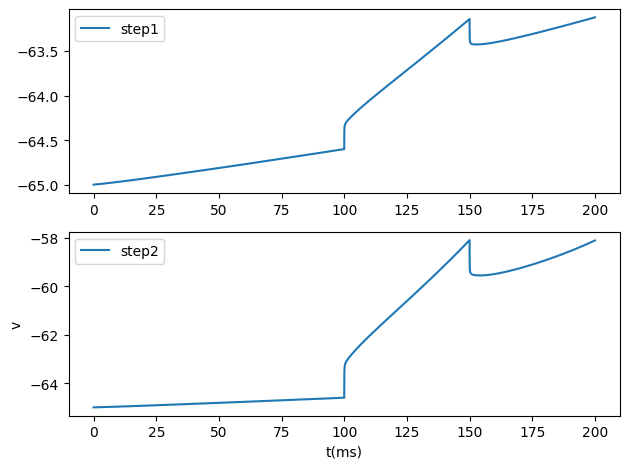

In [4]:
responses = sweep(cell_model)
plot_responses(responses)